# Setup

In [1]:
import copy
import json

import numpy as np
import palettable

In [2]:
from boilerplate_builder import BoilerplateBuilder

In [3]:
scene_dir_from_nb_dir = "../../scenes"
scene_dir_from_exec_dir = "../../scenes"
scenes = [
    "initial_conditions",
]

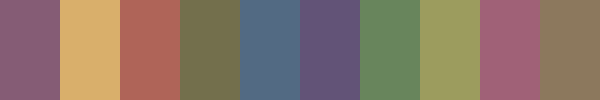

In [4]:
color_scheme = palettable.cartocolors.qualitative.Antique_10
colors = (np.array(color_scheme.mpl_colors) * 255).astype(int)
colors = np.hstack([colors, np.full((colors.shape[0], 1), 255)])
color_scheme.show_discrete_image()

In [5]:
bb = BoilerplateBuilder()

In [6]:
# Load the components_by_file json for validation
with open("components_by_file.json") as f:
    components_by_file = json.load(f)

# Main Scene

In [7]:
scene_key = "main_scene"

In [8]:
scene_data = {}

In [9]:
scene_key_i = "initial_conditions"
scene_data[scene_key_i] = {
    "components": {
        "SceneComp": {
            "scene_fp": f"{scene_dir_from_exec_dir}/{scene_key_i}.json",
            "emplace_after_loading": True,
            "emplace_order": -1,
        }
    },
}

In [10]:
# UI must be added after the scene is loaded to ensure the player exists first
scene_key_i = "user_interface"
scene_data[scene_key_i] = {
    "components": {
        "SceneComp": {
            "scene_fp": f"{scene_dir_from_exec_dir}/{scene_key_i}.json",
            "emplace_after_loading": True,
        }
    },
}

In [11]:
scene_key_i = "projectiles"
scene_data[scene_key_i] = {
    "components": {
        "SceneComp": {
            "scene_fp": f"{scene_dir_from_exec_dir}/{scene_key_i}.json",
        }
    },
}

In [12]:
bb.save_scene_to_json(
    scene_key,
    scene_dir_from_nb_dir,
    scene_data,
    components_by_file["system_components"],
)

# User Interface

In [13]:
scene_key = "user_interface"
scene_data = {}

In [14]:
scene_data["durability_bar"] = {
    "components": {"UIComp": {"tracked_entity_name": "[PlayerComp|first]"}}
}

In [15]:
bb.save_scene_to_json(
    scene_key,
    scene_dir_from_nb_dir,
    scene_data,
    components_by_file["system_components"],
)

Adding UnresolvedNameComp to 'durability_bar'


# Initial Conditions

In [16]:
scene_key = "initial_conditions"
scene_data = {}

In [17]:
scene_data["player"] = {
    "components": {
        "PhysicsComp": {},
        "DragForceComp": {"drag_coefficient": 0.05, "drag_power": 2.5},
        "DurabilityComp": {"delete_at_zero": False},
        "RenderComp": {"radius": 1.0, "fill_color": colors[2].tolist()},
        "SceneTriggerComp": {"scene_name": "[SceneComp|name:projectiles]"},
        "StopWatchComp": {},
        "PlayerComp": {},
        "ViewComp": {},
    }
}

In [18]:
scene_data["beacon"] = {
    "components": {
        "PhysicsComp": {},
        "MouseButtonReleasedComp": {},
        "RenderComp": {
            "radius": 0.5,
            "outline_thickness": 0.1,
            "fill_color": [0, 0, 0, 255],
            "outline_color": [255, 255, 255, 255],
            "zorder": 1,
        },
    }
}

In [19]:
scene_data["player-beacon force"] = {
    "components": {
        "PairComp": {"target_entity_name": "player", "source_entity_name": "beacon"},
        "PairwiseForceComp": {"magnitude": -2.0},
    }
}

In [20]:
n_enemies = 10
rng = np.random.default_rng()
xs = rng.uniform(-100, 100, n_enemies)
ys = rng.uniform(-120, -20, n_enemies)
for i in range(n_enemies):
    # Enemies themselves
    scene_data[f"enemy.{i:03d}"] = {
        "components": {
            "EnemyComp": {},
            "PhysicsComp": {
                "pos": [xs[i], ys[i]],
                "vel": [0.0, 0.0],
            },
            "DragForceComp": {},
            "DurabilityComp": {},
            "RenderComp": {
                "radius": 1.0,
                "fill_color": colors[3].tolist(),
            },
        }
    }

    # Relationships between enemies and player
    scene_data[f"enemy-player.{i:03d} inverse square"] = {
        "components": {
            "PairComp": {
                "source_entity_name": "player",
                "target_entity_name": f"enemy.{i:03d}",
            },
            "PairwiseForceComp": {
                "magnitude": -1.0,
                "power": -2.0,
                "softening": 1.0,
                "distance_scaling": 1.0,
            },
        }
    }
    scene_data[f"enemy-player.{i:03d} spring"] = {
        "components": {
            "PairComp": {
                "source_entity_name": "player",
                "target_entity_name": f"enemy.{i:03d}",
            },
            "PairwiseForceComp": {
                "magnitude": -1.0,
            },
        }
    }
    scene_data[f"enemy-player.{i:03d} collision"] = {
        "components": {
            "PairComp": {
                "source_entity_name": "player",
                "target_entity_name": f"enemy.{i:03d}",
            },
            "CollisionComp": {},
        }
    }

In [21]:
# Enemy-enemy collisions
for i in range(n_enemies):
    for j in range(n_enemies):
        if i >= j:
            continue
        scene_data[f"enemy.{i:03d}-enemy.{j:03d} collision"] = {
            "components": {
                "PairComp": {
                    "source_entity_name": f"enemy.{i:03d}",
                    "target_entity_name": f"enemy.{j:03d}",
                },
                "CollisionComp": {},
            }
        }

In [22]:
n_bkgrd = 100
for i in range(n_bkgrd):
    scene_data[f"bkgrd.{i:03d}"] = {
        "components": {
            "PhysicsComp": {},
            "RenderComp": {
                "radius": 10.0 * i,
                "outline_thickness": 0.2,
                "fill_color": [127, 127, 127, 255],
                "outline_color": [63, 63, 63, 255],
                "zorder": -i - 100,
            },
        }
    }

In [23]:
bb.save_scene_to_json(
    scene_key,
    scene_dir_from_nb_dir,
    scene_data,
    components_by_file["system_components"],
)

Adding UnresolvedNameComp to 'player'
Adding UnresolvedNameComp to 'player-beacon force'
Adding UnresolvedNameComp to 'enemy-player.000 inverse square'
Adding UnresolvedNameComp to 'enemy-player.000 spring'
Adding UnresolvedNameComp to 'enemy-player.000 collision'
Adding UnresolvedNameComp to 'enemy-player.001 inverse square'
Adding UnresolvedNameComp to 'enemy-player.001 spring'
Adding UnresolvedNameComp to 'enemy-player.001 collision'
Adding UnresolvedNameComp to 'enemy-player.002 inverse square'
Adding UnresolvedNameComp to 'enemy-player.002 spring'
Adding UnresolvedNameComp to 'enemy-player.002 collision'
Adding UnresolvedNameComp to 'enemy-player.003 inverse square'
Adding UnresolvedNameComp to 'enemy-player.003 spring'
Adding UnresolvedNameComp to 'enemy-player.003 collision'
Adding UnresolvedNameComp to 'enemy-player.004 inverse square'
Adding UnresolvedNameComp to 'enemy-player.004 spring'
Adding UnresolvedNameComp to 'enemy-player.004 collision'
Adding UnresolvedNameComp to 'e

# Projectiles

In [24]:
scene_key = "projectiles"
scene_data = {}

In [25]:
scene_data["projectile"] = {
    "components": {
        "PhysicsComp": {},
        "DragForceComp": {},
        "DurabilityComp": {"durability_loss_per_collision": 1.01},
        "RenderComp": {
            "radius": 0.5,
            "fill_color": colors[4].tolist(),
            "zorder": -1,
        },
    }
}

In [26]:
scene_data["projectile-player sync"] = {
    "components": {
        "PairComp": {
            "target_entity_name": "projectile",
            "source_entity_name": "[PlayerComp|first]",
        },
        "SyncPositionComp": {
            "once_only": True,
        },
    }
}

In [27]:
scene_data["projectile-enemy force"] = {
    "components": {
        "PairComp": {
            "target_entity_name": "projectile",
            "source_entity_name": "[EnemyComp|first]",
        },
        "PairwiseForceComp": {"magnitude": -10.0},
    }
}

In [28]:
scene_data["projectile-enemy collisions"] = {
    "components": {
        "PairComp": {
            "source_entity_name": "projectile",
            "target_entity_name": "[EnemyComp|first]",
        },
        "CollisionComp": {},
    }
}

In [29]:
bb.save_scene_to_json(
    scene_key,
    scene_dir_from_nb_dir,
    scene_data,
    components_by_file["system_components"],
)

Adding UnresolvedNameComp to 'projectile-player sync'
Adding UnresolvedNameComp to 'projectile-enemy force'
Adding UnresolvedNameComp to 'projectile-enemy collisions'


# Test Scene

In [30]:
scene_key = "test_scene"

In [31]:
test_scene_dir_from_exec_dir = "../../tests/test_data"

In [32]:
scene_data = {}

In [33]:
scene_data["player"] = {
    "components": {
        "PhysicsComp": {
            "mass": 1.0,
            "pos": [1.0, 1.0],
            "vel": [2.0, 2.0],
            "collided": True,
        },
        "DragForceComp": {"drag_coefficient": 0.05, "drag_power": 2.5},
        "DurabilityComp": {"delete_at_zero": False},
        "RenderComp": {"radius": 1.0, "fill_color": [255, 128, 128, 255]},
        "SceneTriggerComp": {"scene_name": "[SceneComp|name:triggered_scene]"},
        "StopWatchComp": {},
        "ViewComp": {},
        "UnresolvedNameComp": {},
    }
}

In [34]:
scene_data["beacon"] = {
    "components": {
        "PhysicsComp": {},
        "MouseButtonReleasedComp": {},
        "RenderComp": {
            "radius": 0.5,
            "outline_thickness": 0.1,
            "fill_color": [0, 0, 0, 255],
            "outline_color": [255, 255, 255, 255],
            "zorder": 1,
        },
    }
}

In [35]:
scene_data["player-beacon force"] = {
    "components": {
        "PairComp": {"target_entity_name": "player", "source_entity_name": "beacon"},
        "PairwiseForceComp": {"magnitude": -1.0},
        "UnresolvedNameComp": {},
    }
}

In [36]:
scene_data[f"bkgrd"] = {
    "components": {
        "PhysicsComp": {},
        "RenderComp": {
            "radius": 10.0,
            "outline_thickness": 0.2,
            "fill_color": [127, 127, 127, 255],
            "outline_color": [63, 63, 63, 255],
            "zorder": - 101,
        },
    }
}

In [37]:
scene_data["triggered_scene"] = {
    "components": {
        "SceneComp": {
            "scene_fp": f"{test_scene_dir_from_exec_dir}/triggered_scene.json",
        },
    },
}

In [38]:
bb.save_scene_to_json(
    scene_key,
    test_scene_dir_from_exec_dir,
    scene_data,
    components_by_file["system_components"],
)

Adding UnresolvedNameComp to 'player'
Adding UnresolvedNameComp to 'player-beacon force'
